In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pynapple as nap
from spatial_manifolds.toroidal import *
from spatial_manifolds.behaviour_plots import *
from matplotlib.colors import TwoSlopeNorm
from scipy.spatial import distance

from spatial_manifolds.data.curation import curate_clusters
from scipy.stats import zscore
from spatial_manifolds.util import gaussian_filter_nan
from spatial_manifolds.predictive_grid import compute_travel_projected, wrap_list
from spatial_manifolds.behaviour_plots import *
from spatial_manifolds.behaviour_plots import trial_cat_priority

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [19]:
mouse = 25
day =  25

session = 'OF1'
of1_folder = f'/Users/harryclark/Downloads/COHORT12_nwb/M{mouse}/D{day:02}/{session}/'
grid_path = of1_folder + "tuning_scores/grid_score.parquet"
shifted_grid_path = of1_folder + "tuning_scores/shifted_grid_score.parquet"
spatial_path = of1_folder + "tuning_scores/shifted_spatial_information.parquet"
spikes_path = of1_folder + f"sub-{mouse}_day-{day:02}_ses-{session}_srt-kilosort4_clusters.npz"
beh_path = of1_folder + f"sub-{mouse}_day-{day:02}_ses-{session}_beh.nwb"
active_projects_path = Path("/Volumes/cmvm/sbms/groups/CDBS_SIDB_storage/NolanLab/ActiveProjects/")
anatomy_path = active_projects_path / "Chris/Cohort12/derivatives/labels/anatomy/cluster_annotations.csv"
cluster_locations = pd.read_csv(anatomy_path)
beh_OF = nap.load_file(beh_path)
clusters_OF = nap.load_file(spikes_path)
shifted_grid_scores_of1 = pd.read_parquet(shifted_grid_path)
spatial_information_score_of1 = pd.read_parquet(spatial_path)


In [3]:
cluster_ids_values = shifted_grid_scores_of1.query('travel == 0').cluster_id

non_grid_cells = pd.DataFrame()
grid_cells = pd.DataFrame()
non_spatial_cells = pd.DataFrame()
cells = pd.DataFrame()

for index in cluster_ids_values:

    cluster_spatial_information_of1 = spatial_information_score_of1[spatial_information_score_of1.cluster_id==index]
    cluster_shifted_grid_scores_of1 = shifted_grid_scores_of1[shifted_grid_scores_of1.cluster_id==index]

    percentile99_grid_score_of1 = np.nanpercentile(cluster_shifted_grid_scores_of1.null_grid_score.iloc[0], 95)
    percentile99_spatial_information_of1 = np.nanpercentile(cluster_spatial_information_of1.null_spatial_information.iloc[0], 95)

    field_spacing = cluster_shifted_grid_scores_of1.field_spacing.values[np.nanargmax(cluster_shifted_grid_scores_of1.grid_score)]
    orientation = cluster_shifted_grid_scores_of1.orientation.values[np.nanargmax(cluster_shifted_grid_scores_of1.grid_score)]
    
    max_grid_score_of1 = cluster_shifted_grid_scores_of1.grid_score.values[np.nanargmax(cluster_shifted_grid_scores_of1.grid_score)]
    spatial_info = cluster_spatial_information_of1.spatial_information.values[np.nanargmax(cluster_shifted_grid_scores_of1.grid_score)]
    spatial_info_no_lag = cluster_spatial_information_of1.spatial_information.iloc[0]

    cell = shifted_grid_scores_of1[shifted_grid_scores_of1.grid_score==max_grid_score_of1]

    if (max_grid_score_of1 > percentile99_grid_score_of1) and (spatial_info > percentile99_spatial_information_of1) and (max_grid_score_of1>0.4):
        grid_cells = pd.concat([grid_cells, cell], ignore_index=True)
    elif (spatial_info_no_lag > percentile99_spatial_information_of1):
        non_grid_cells = pd.concat([non_grid_cells, cell], ignore_index=True)
    else:
        non_spatial_cells = pd.concat([non_spatial_cells, cell], ignore_index=True)
    cells = pd.concat([cells, cell], ignore_index=True)
    
all_cells = cells.copy()
grid_cells = grid_cells.sort_values(by=['field_spacing'])
non_grid_cells = non_grid_cells.sort_values(by=['field_spacing'])
non_spatial_cells = non_spatial_cells.sort_values(by=['field_spacing'])
non_grid_and_non_spatial_cells = pd.concat([non_grid_cells, non_spatial_cells], ignore_index=True)

print(f'there are {len(non_grid_and_non_spatial_cells)} non_grid and non_spatial_cells')
print(f'there are {len(grid_cells)} grid_cells')
print(f'there are {len(non_grid_cells)} non grid spatial cells')
print(f'there are {len(non_spatial_cells)} non spatial cells')
print(f'there are {len(all_cells)} cells')


there are 98 non_grid and non_spatial_cells
there are 54 grid_cells
there are 53 non grid spatial cells
there are 45 non spatial cells
there are 152 cells


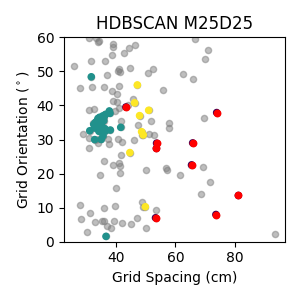

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

samples = np.stack([np.array(grid_cells['field_spacing']),
                    np.cos((np.array(grid_cells['orientation'])/60) * 2 * np.pi),
                    np.sin((np.array(grid_cells['orientation'])/60) * 2 * np.pi)]).T

samples2d = np.stack([np.array(grid_cells['field_spacing']),
                    np.array(grid_cells['orientation'])]).T

# Standardize the data
scaler = StandardScaler()
samples_scaled = scaler.fit_transform(samples)
samples_scaled[:, 1] /= np.sqrt(2)
samples_scaled[:, 2] /= np.sqrt(2)

samples_scaled = samples

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=3)
module_labels = clusterer.fit_predict(samples_scaled)

# Plot the results
plt.figure(figsize=(3, 3))
scatter = plt.scatter(samples2d[:, 0], samples2d[:, 1], c=module_labels, s=20, cmap='viridis', label='Clustered Points')
label_colors = {label: cm.get_cmap('viridis', len(np.unique(module_labels)))(i) for i, label in enumerate(np.unique(module_labels))}

# Highlight unassigned points (label -1)
unassigned = samples2d[module_labels == -1]
plt.scatter(unassigned[:, 0], unassigned[:, 1], s=21, color='red', label='Unassigned Points')
plt.scatter(all_cells['field_spacing'], all_cells['orientation'], s=20, color='tab:grey', alpha=0.5,zorder=-1)

#plt.legend()
plt.xlabel('Grid Spacing (cm)')
plt.ylabel('Grid Orientation ($^\circ$)')
plt.ylim(0,60)
plt.title(f'HDBSCAN M{mouse}D{day}')
plt.tight_layout()
plt.savefig(f'/Users/harryclark/Documents/figs/SUPP_Grid_module_classification/HDBSCAN_M{mouse}D{day}.pdf')
plt.show()


In [5]:
# put cluster ids into modules then rearange from smallest spacing to larger
grid_module_cluster_ids = []
avg_spacings = []
for mi, module_label in enumerate(np.unique(module_labels[module_labels != -1])):
    grid_ids = np.array(grid_cells['cluster_id'])
    cells = grid_cells[np.isin(grid_cells['cluster_id'], grid_ids[module_labels == module_label])]
    avg_spacings.append(np.nanmean(cells.field_spacing.values))
    grid_module_cluster_ids.append(cells['cluster_id'].tolist())
grid_module_cluster_ids = [x for _, x in sorted(zip(avg_spacings, grid_module_cluster_ids))]

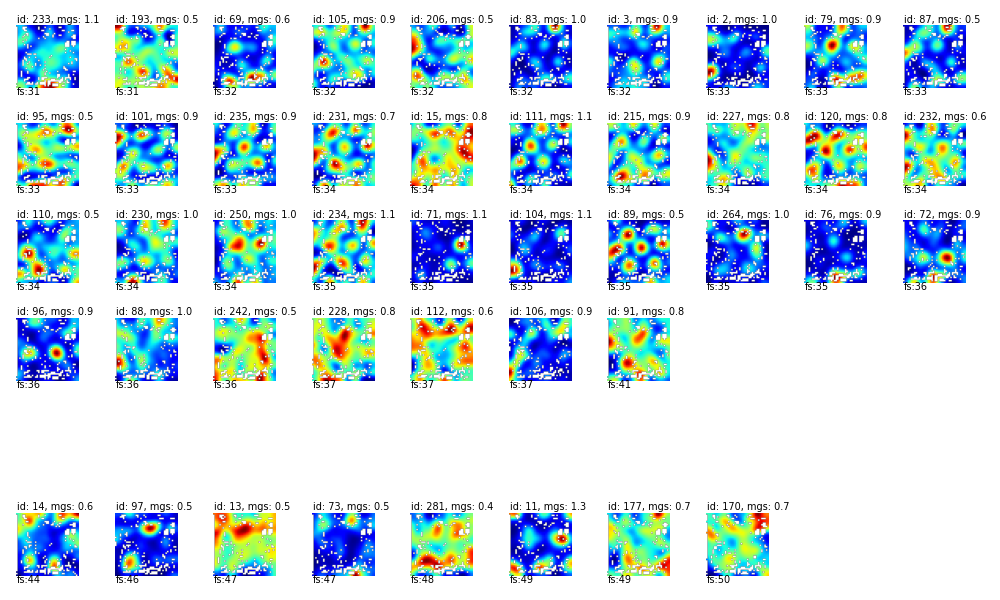

In [7]:
ncols = 10
rows_per_module = [int(np.ceil(len(module) / ncols)) for module in grid_module_cluster_ids]
nrows = sum(rows_per_module)+len(grid_module_cluster_ids)-1
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 1*nrows), squeeze=False)
row_counter = 0
for mi, module_ids in enumerate(grid_module_cluster_ids):
    cells = grid_cells[grid_cells['cluster_id'].isin(module_ids)]
    counter = 0
    for j in range(rows_per_module[mi]):
        for i in range(ncols):
            if counter < len(cells):
                index = cells['cluster_id'].values[counter]
                score = cells['grid_score'].values[counter]
                cluster_shifted_grid_scores = shifted_grid_scores_of1[shifted_grid_scores_of1.cluster_id==index]
                travel = cluster_shifted_grid_scores.travel.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]
                max_score = cluster_shifted_grid_scores.grid_score.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]
                field_spacing = cluster_shifted_grid_scores.field_spacing.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]
                
                tcs = {}    
                position = np.stack([beh_OF['P_x'], beh_OF['P_y']], axis=1)
                beh_lag = compute_travel_projected(["P_x", "P_y"], position, position, travel)
                position_lagged = np.stack([beh_lag['P_x'], beh_lag['P_y']], axis=1)
                for cell in cells['cluster_id'].values:
                    tc = nap.compute_2d_tuning_curves(nap.TsGroup([clusters_OF[cell]]), position_lagged, nb_bins=(40,40))[0]
                    tc = gaussian_filter_nan(tc[0], sigma=(2.5,2.5))
                    tcs[cell] = tc
                ax[row_counter, i].text(0,-2, f'id: {index}, mgs: {np.round(max_score, decimals=1)}', size=7)
                ax[row_counter, i].text(0,44, f'fs:{int(field_spacing)}', size=7)
                ax[row_counter, i].imshow(tcs[index], cmap='jet')
                counter+=1
        row_counter += 1
    row_counter += 1

for axi in ax.flatten():
    axi.axis('off')
plt.tight_layout()
plt.savefig(f'/Users/harryclark/Documents/figs/SUPP_Grid_module_classification/GC_rate_maps_modules_M{mouse}D{day}.pdf')
plt.show()

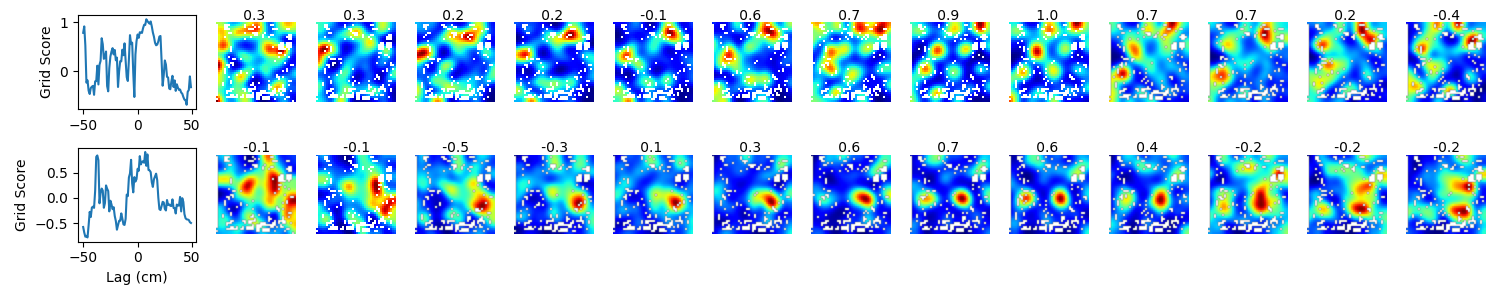

In [56]:
fig, ax = plt.subplots(ncols=14, nrows=2, figsize=(15, 3), squeeze=False, width_ratios=[1.5,1,1,1,1,1,1,1,1,1,1,1,1,1])
index = 111
cluster_shifted_grid_scores = shifted_grid_scores_of1[shifted_grid_scores_of1.cluster_id==index]
travel = cluster_shifted_grid_scores.travel.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]
max_score = cluster_shifted_grid_scores.grid_score.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]
field_spacing = cluster_shifted_grid_scores.field_spacing.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]

for i, travel in enumerate([-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30]):
    position = np.stack([beh_OF['P_x'], beh_OF['P_y']], axis=1)
    beh_lag = compute_travel_projected(["P_x", "P_y"], position, position, travel)
    position_lagged = np.stack([beh_lag['P_x'], beh_lag['P_y']], axis=1)
    tc = nap.compute_2d_tuning_curves(nap.TsGroup([clusters_OF[index]]), position_lagged, nb_bins=(40,40))[0]
    tc = gaussian_filter_nan(tc[0], sigma=(2.5,2.5))
    gs = cluster_shifted_grid_scores[cluster_shifted_grid_scores.travel ==travel]['grid_score'].iloc[0]
    ax[0, i+1].text(0,-2, f'      {np.round(gs, decimals=1)}', size=10)
    ax[0, i+1].imshow(tc, cmap='jet')
    ax[0, i+1].axis('off')
gs = []
for travel in np.unique(cluster_shifted_grid_scores.travel):
    gs.append(cluster_shifted_grid_scores[cluster_shifted_grid_scores.travel == travel]['grid_score'].iloc[0])
ax[0, 0].plot(np.unique(cluster_shifted_grid_scores.travel), gs)
ax[0, 0].set_ylabel('Grid Score')


index = 96
cluster_shifted_grid_scores = shifted_grid_scores_of1[shifted_grid_scores_of1.cluster_id==index]
travel = cluster_shifted_grid_scores.travel.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]
max_score = cluster_shifted_grid_scores.grid_score.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]
field_spacing = cluster_shifted_grid_scores.field_spacing.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]

for i, travel in enumerate([-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30]):
    position = np.stack([beh_OF['P_x'], beh_OF['P_y']], axis=1)
    beh_lag = compute_travel_projected(["P_x", "P_y"], position, position, travel)
    position_lagged = np.stack([beh_lag['P_x'], beh_lag['P_y']], axis=1)
    tc = nap.compute_2d_tuning_curves(nap.TsGroup([clusters_OF[index]]), position_lagged, nb_bins=(40,40))[0]
    tc = gaussian_filter_nan(tc[0], sigma=(2.5,2.5))
    gs = cluster_shifted_grid_scores[cluster_shifted_grid_scores.travel ==travel]['grid_score'].iloc[0]
    ax[1, i+1].text(0,-2, f'      {np.round(gs, decimals=1)}', size=10)
    ax[1, i+1].imshow(tc, cmap='jet')
    ax[1, i+1].axis('off')
gs = []
for travel in np.unique(cluster_shifted_grid_scores.travel):
    gs.append(cluster_shifted_grid_scores[cluster_shifted_grid_scores.travel == travel]['grid_score'].iloc[0])
ax[1, 0].plot(np.unique(cluster_shifted_grid_scores.travel), gs)
ax[1, 0].set_xlabel('Lag (cm)')
ax[1, 0].set_ylabel('Grid Score')

plt.tight_layout()
plt.show()
fig.savefig(f'/Users/harryclark/Documents/figs/SUPP_Grid_module_classification/M{mouse}D{day}_rate_maps_lagged.pdf', dpi=300, bbox_inches='tight')
